<img src="./assets/1603206853202.jfif" />

In [127]:
from tkinter import *
from tkinter import filedialog
from tkinter import Tk
import json
import numpy as np
import matplotlib.pyplot as plt
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 
import spotipy.util as util
from datetime import date
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
# disable chained assignments
pd.options.mode.chained_assignment = None 


In [102]:
# Quickly get rid of the root window popup
root = Tk()
root.withdraw()

try:
    # Use Filedialog.askopenfilename to open a dialog window where you can select your credentials file.
    filepath = filedialog.askopenfilename()
    file = open(filepath, 'r')

    # Open the credentials file with json.load
    credentials = json.load(file)
    file.close()
    
    # Assign global authrization variables
    spotify_cid = credentials['spotify_cid']
    spotify_secret = credentials['spotify_secret']
    spotify_username = credentials['spotify_username']
    spotify_scope = credentials['spotify_scope']
    spotify_redirect_uri = credentials["spotify_redirect_uri"]
except:
    print("Something went wrong, please choose the correct json file")


In [138]:
def get_spotify_manager():
    token = util.prompt_for_user_token(spotify_username,spotify_scope,client_id=spotify_cid,client_secret=spotify_secret,redirect_uri=spotify_redirect_uri)
    client_credentials_manager = SpotifyClientCredentials(client_id=spotify_cid, client_secret=spotify_secret)
    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [139]:
#get spotify instance
sp = get_spotify_manager()

In [140]:
class spotify_data:
  def __init__(self, artist_name, track_name , track_id , popularity , release_date):
    self.artist_name = artist_name
    self.track_name = track_name
    self.track_id = track_id
    self.popularity = self.get_normalized_popularity(popularity)
    self.release_date_year = self.get_normalized_release_date_year(release_date)

  def get_normalized_popularity(self, popularity):
    return popularity / 100
    
  def get_normalized_release_date_year(self, release_date_year):
    try:
        return release_date_year[0:release_date_year.index('-')]
    except:
        return release_date_year

In [141]:
def get_spotify_query_random_year(year):
    return f'year:{year + random.randint(0, 9)}'

def get_spotify_data(year_start, year_end, year_inc):
    list = []
    while year_start <= year_end:
        for i in range(0,1000,50):
            track_results = sp.search(q=get_spotify_query_random_year(year_start), type='track', limit=50, offset=i)
            for i, t in enumerate(track_results['tracks']['items']):
                list.append( spotify_data(t['artists'][0]['name'] , t['name'], t['id'] ,t['popularity'] , t['album']['release_date']))
        year_start = year_start + year_inc    
    return list

In [142]:
# printing some valueable stuff
print("Hey there, be patient on the next cell it will take some time to fetch huge amount of data")

Hey there, be patient on the next cell it will take some time to fetch huge amount of data


In [143]:
# get spotify data
year_start = 1970
year_end = 1990
year_inc = 10
nrows = ((year_end - year_start) / 10) + 1
spotify_data_list = get_spotify_data(year_start , year_end , year_inc) #we would like to take songs from the 70's 80's 90's

In [144]:
#create df from class list
df_tracks = pd.DataFrame([item.__dict__ for item in spotify_data_list])

In [145]:
#lets check the df is ok
df_tracks.head()

,artist_name,track_name,track_id,popularity,release_date_year
0,Lynyrd Skynyrd,Sweet Home Alabama,7e89621JPkKaeDSTQ3avtg,0.80,1974
1,Queen,Killer Queen - Remastered 2011,7GqWnsKhMtEW0nzki5o0d8,0.67,1974
2,Bachman-Turner Overdrive,You Ain't Seen Nothing Yet,0HOrDVS349XFcpCYsO2hAP,0.72,1974
3,Dolly Parton,Jolene,2SpEHTbUuebeLkgs9QB7Ue,0.72,1974
4,David Bowie,Rebel Rebel - 2016 Remaster,2EC9IJj7g0mN1Q5VrZkiYY,0.72,1974


In [146]:
# remove duplicates - group the entries by specific columns
group_by_columns = ['artist_name','track_name']
grouped = df_tracks.groupby(group_by_columns, as_index=True).size()

In [147]:
# lets check number of duplicates we found
print(f"num of duplicated items by {', '.join(group_by_columns)}: {grouped[grouped > 1].count()}")

num of duplicated items by artist_name, track_name: 22


In [148]:
# dropping duplicates by specific columns
df_tracks.drop_duplicates(subset=group_by_columns, inplace=True)

In [149]:
# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('number of tracks where no audio features were available:',None_counter)

number of tracks where no audio features were available: 0


In [150]:
# saving the features in a data frame
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
# lets check the shape 
print("Shape of the dataset:", df_audio_features.shape)
# let check audio features df
df_audio_features.head()

Shape of the dataset: (2978, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.596,0.605,7,-12.145,1,0.0255,0.181000,0.000331,0.0863,0.886,97.798,audio_features,7e89621JPkKaeDSTQ3avtg,spotify:track:7e89621JPkKaeDSTQ3avtg,https://api.spotify.com/v1/tracks/7e89621JPkKa...,https://api.spotify.com/v1/audio-analysis/7e89...,283800,4
1,0.535,0.650,10,-6.328,1,0.0554,0.379000,0.000000,0.1400,0.610,117.188,audio_features,7GqWnsKhMtEW0nzki5o0d8,spotify:track:7GqWnsKhMtEW0nzki5o0d8,https://api.spotify.com/v1/tracks/7GqWnsKhMtEW...,https://api.spotify.com/v1/audio-analysis/7GqW...,179600,4
2,0.475,0.439,11,-15.039,0,0.0427,0.000146,0.000277,0.2230,0.760,118.392,audio_features,0HOrDVS349XFcpCYsO2hAP,spotify:track:0HOrDVS349XFcpCYsO2hAP,https://api.spotify.com/v1/tracks/0HOrDVS349XF...,https://api.spotify.com/v1/audio-analysis/0HOr...,234867,4
3,0.674,0.537,1,-10.971,0,0.0363,0.566000,0.000000,0.1310,0.809,110.578,audio_features,2SpEHTbUuebeLkgs9QB7Ue,spotify:track:2SpEHTbUuebeLkgs9QB7Ue,https://api.spotify.com/v1/tracks/2SpEHTbUuebe...,https://api.spotify.com/v1/audio-analysis/2SpE...,161533,4
4,0.635,0.686,9,-15.648,1,0.0530,0.209000,0.017600,0.2820,0.464,125.988,audio_features,2EC9IJj7g0mN1Q5VrZkiYY,spotify:track:2EC9IJj7g0mN1Q5VrZkiYY,https://api.spotify.com/v1/tracks/2EC9IJj7g0mN...,https://api.spotify.com/v1/audio-analysis/2EC9...,274747,4


In [151]:
# dropping some not relevant columns
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)
# change column
df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

In [152]:
# merge both dataframes 
df_spotify_data = pd.merge(df_tracks,df_audio_features,on='track_id',how='inner')
# lets check df_spotify_data
df_spotify_data.head()

,artist_name,track_name,track_id,popularity,release_date_year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Lynyrd Skynyrd,Sweet Home Alabama,7e89621JPkKaeDSTQ3avtg,0.80,1974,0.596,0.605,7,-12.145,1,0.0255,0.181000,0.000331,0.0863,0.886,97.798,283800,4
1,Queen,Killer Queen - Remastered 2011,7GqWnsKhMtEW0nzki5o0d8,0.67,1974,0.535,0.650,10,-6.328,1,0.0554,0.379000,0.000000,0.1400,0.610,117.188,179600,4
2,Bachman-Turner Overdrive,You Ain't Seen Nothing Yet,0HOrDVS349XFcpCYsO2hAP,0.72,1974,0.475,0.439,11,-15.039,0,0.0427,0.000146,0.000277,0.2230,0.760,118.392,234867,4
3,Dolly Parton,Jolene,2SpEHTbUuebeLkgs9QB7Ue,0.72,1974,0.674,0.537,1,-10.971,0,0.0363,0.566000,0.000000,0.1310,0.809,110.578,161533,4
4,David Bowie,Rebel Rebel - 2016 Remaster,2EC9IJj7g0mN1Q5VrZkiYY,0.72,1974,0.635,0.686,9,-15.648,1,0.0530,0.209000,0.017600,0.2820,0.464,125.988,274747,4


In [153]:
# lets create some helpers methods
def get_grouped_sorted_by_avg_df(df ,group_by , sort_by, asc):
    df.groupby(by=group_by)[sort_by].mean()
    return df.sort_values([sort_by], ascending=[asc])


def get_frequent_elements(df, col_name, num_top_elements):
    data_list = df[col_name].value_counts(ascending=False)[:num_top_elements].sort_index()
    return pd.Series(data=data_list)

def get_first_N_rows(df,n):
    return df.head(n)

def get_normalized_current_df_by_decade(df , year , group_by , sort_by , concated_col_name , concat_col_1 , concat_col_2):
    df_current = get_grouped_sorted_by_avg_df(df,group_by,sort_by,False)
    df_current = get_first_N_rows(df_current,30)
    df_current.sort_values(sort_by, inplace=True)
    df_current[concated_col_name] = df_current[concat_col_1].str.cat(df_current[[concat_col_2]].astype(str), sep=" - ")
    #df_current["artist_with_song"] = df_current["artist_name"].str.cat(df_current[["track_name"]].astype(str), sep=" - ")
    df_current['popularity'] = df_current['popularity'] * 10
    return df_current

In [154]:
# lets define some viaulizations methods
def show_correlation(df, title):
    # Plot
    plt.figure(figsize=(16,10), dpi= 80)
    sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

    # Decorations
    plt.title(title, fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()    
    
    
def show_bar(df, title, group_by, x_col, y_col, x_label, y_label, ax):
    df.sort_values(y_col, inplace=True)
    df.reset_index(inplace=True)
    ax.vlines(x=df.index, ymin=0, ymax=df[y_col], color='firebrick', alpha=0.7, linewidth=20)

    # Annotate Text
    for i, item in enumerate(df[y_col]):
        ax.text(i, item+0.5, round(item, 1), horizontalalignment='center')
        
    # Title, Label, Ticks and Ylim
    ax.set_title(title, fontdict={'size':22})
    ax.set(xlabel=x_label,ylabel=y_label, ylim=(0, 10))

    plt.subplots_adjust(left=1.1,
                    bottom=1.1, 
                    right=1.9, 
                    top=2.9, 
                    wspace=1.4, 
                    hspace=1.4)
    
    plt.sca(ax)
    plt.xticks(df.index, df[x_col], rotation=60, horizontalalignment='right', fontsize=12)


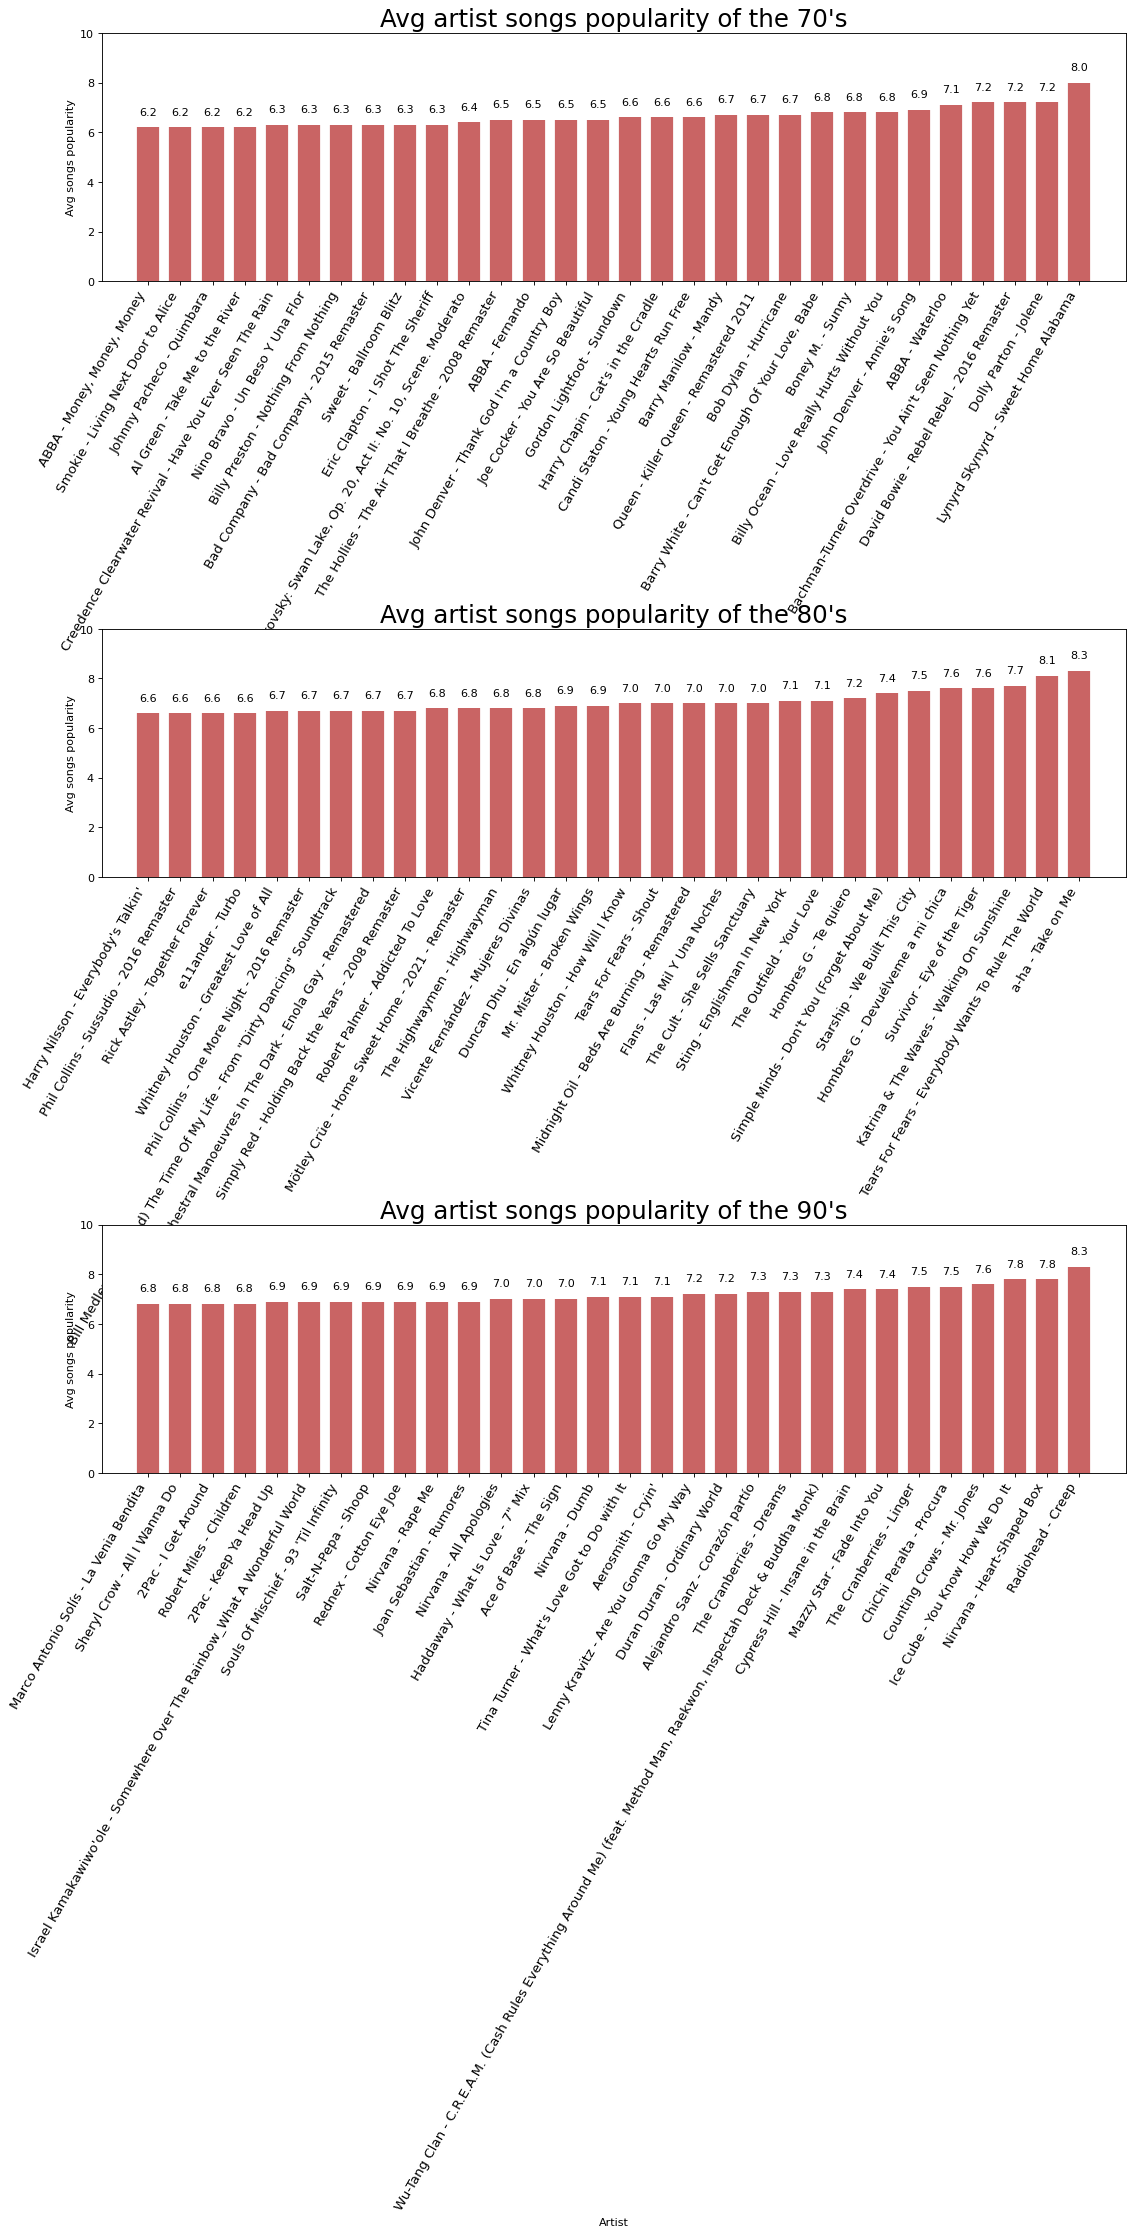

In [155]:
#prepare data #1

fig, ax = plt.subplots(nrows=int(nrows) ,ncols=1,figsize=(16,10), facecolor='white', dpi= 80)
c_d = year_start
i = 0


while(c_d <= year_end):
    #prepare data #2
    df_spotify_data["release_date_year"] = pd.to_numeric(df_spotify_data["release_date_year"]) 
    #df_current = df_spotify_data[(df_spotify_data['release_date_year'] >= c_d) & (df_spotify_data['release_date_year'] < c_d + 9)]    

    #prepare data #3
    df_spotify_data["release_date_year"] = pd.to_numeric(df_spotify_data["release_date_year"]) 
    df_current = df_spotify_data[(df_spotify_data['release_date_year'] >= c_d) & (df_spotify_data['release_date_year'] < c_d + 9)]    
    df_current = df_current[["artist_name","popularity", "release_date_year" , "track_name"]]
    df_current = get_normalized_current_df_by_decade(df_current,
                                                     c_d,
                                                     "artist_name",
                                                     "popularity",
                                                     "artist_with_song",
                                                     "artist_name",
                                                     "track_name")
    
    decade_txt = str(c_d)
    preety_decade = decade_txt[len(decade_txt ) - 2:]
    
    show_bar(df_current,
            f"Avg artist songs popularity of the {preety_decade}'s",
            "artist_name",
            "artist_with_song",
            "popularity",
            "Artist",
            "Avg songs popularity",
             ax[i])

    i += 1
    c_d = c_d + year_inc



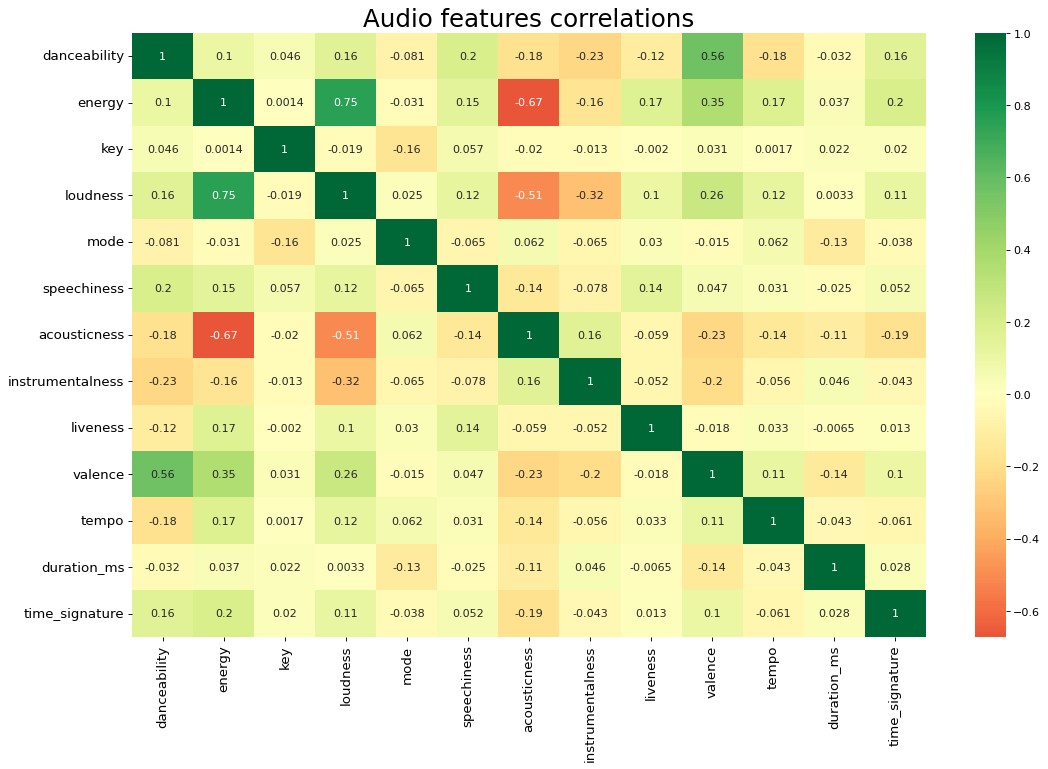

In [156]:
# lets show some viaulizations
show_correlation(df_audio_features, "Audio features correlations")




In [157]:
# lets save the data frame
df_spotify_data.to_csv('spotify_data.csv')

In [158]:
data_copy = df_spotify_data.copy()
feature_cols = ['acousticness', 'instrumentalness', 'loudness', 'energy']
X = data_copy[feature_cols]

popularity = data_copy.popularity
popularity = pd.cut(popularity ,bins=3 , labels=["low","medium","high"] , right=True)
y = popularity
y.value_counts() / y.count()
pop_count = popularity.value_counts()
ros = RandomOverSampler()
X_ros,y_ros = ros.fit_resample(X,y)

print("Removed indexes")
print(X_ros.shape , y_ros.shape)
print("\n")
y_ros.value_counts()
X_ros.value_counts()

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=99, test_size=0.3)
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)


print("Summary:")
print("--------")
cmat = confusion_matrix(y_test, y_pred_class)
print(f"Score: {metrics.accuracy_score(y_test, y_pred_class)}")
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - Flase Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], cmat[2,0], cmat[1,2], cmat[2,1]]), np.sum(cmat))))

Removed indexes
(4548, 4) (4548,)


Summary:
--------
Score: 0.7003663003663003
TP - True Negative 458
FP - Flase Positive 0
FN - False Negative 33
TP - True Positive 231
Accuracy Score: 0.7003663003663003
Misclassification Rate: 0.2996336996336996
